# MAC-LRN Machine Project

#### Members: Nicholas Philson Lee

## Note:

Before running this notebook, download dataset from the link provided.

### Setup

Install necessary libraries:

In [1]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib

Import required libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%matplotlib inline

plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'


%load_ext autoreload
%autoreload 2


### Dataset Initialization

Dataset Source:\
loki4514. (2023). "Rice Leaf Diseases Detection". Retrieved December 2, 2025 from https://www.kaggle.com/datasets/loki4514/rice-leaf-diseases-detection

In [54]:
# Variable initialization
IMAGE_SIZE = 224
KERNEL_SIZE = 3
CONV_FILTERS = 6
CONV_STRIDE = 1
CONV_PADDING = 0
MAXPOOL_SIZE = 2

ADAM_LEARN = 0.001
N_ITERS = 20

# PLACE RELATIVE PATHS TO DIRECTORY HERE
train_directory = "Rice_Leaf_Disease/train_reduced" 
test_directory = "Rice_Leaf_Disease/test_reduced"
test2_directory = "Rice_Leaf_Disease/new"

label_list = ["tungro", "sheath_blight", "rice_hispa", "neck_blast", "narrow_brown_spot", 
              "leaf_scald", "leaf_blast", "healthy", "brown_spot", "bacterial_leaf_blight"]

NUM_LABELS = len(label_list)

REG_RATE = 0.0
DROP_RATE = 0.0

DLAYER1 = 100
DLAYER2 = 100



In [4]:
X_train = tf.keras.utils.image_dataset_from_directory(
	train_directory,
	labels = 'inferred',
	label_mode = 'categorical', # one hot encoding
	class_names = label_list,
	color_mode = 'rgb',
	image_size = (IMAGE_SIZE, IMAGE_SIZE),
    shuffle = True,
	seed = 1203 
)

X_test = tf.keras.utils.image_dataset_from_directory(
	test_directory,
	labels = 'inferred',
	label_mode = 'categorical',
	class_names = label_list,
	color_mode = 'rgb',
	image_size = (IMAGE_SIZE, IMAGE_SIZE),
    shuffle = True,
	seed = 1203 
)

Found 2992 files belonging to 10 classes.
Found 686 files belonging to 10 classes.


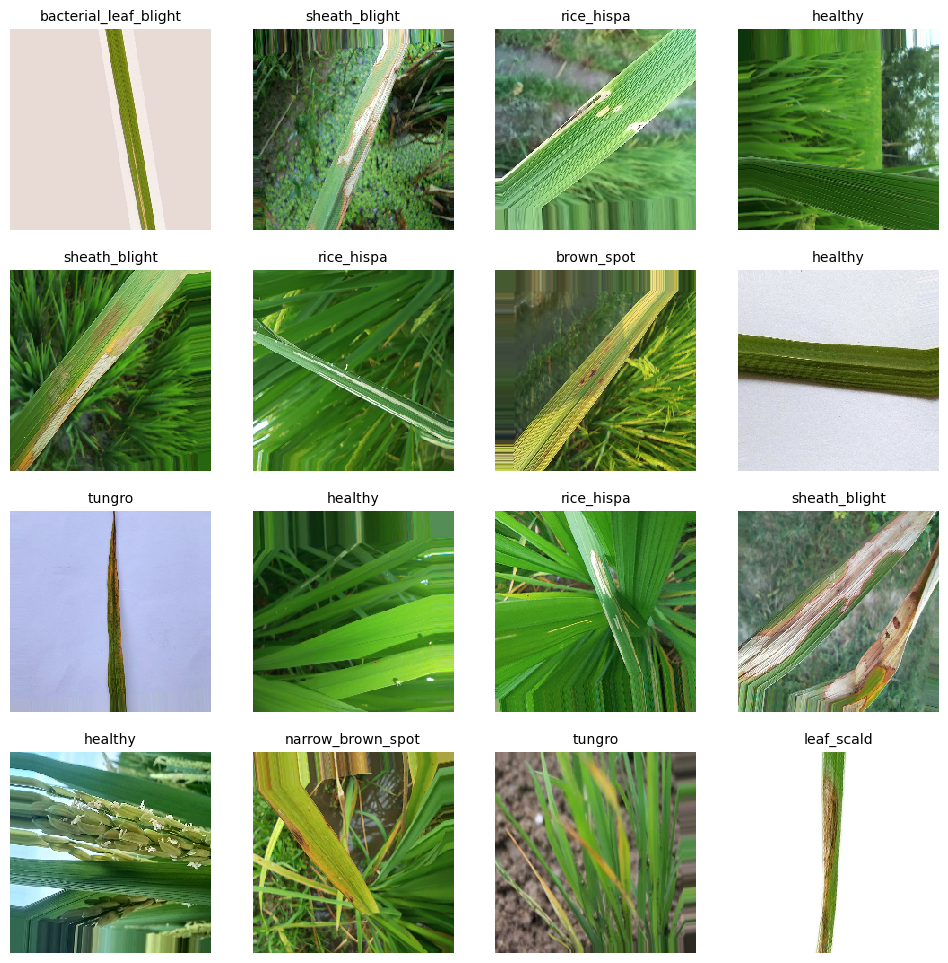

In [55]:
for images, labels in X_train.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(label_list[tf.argmax(labels[i], axis=0).numpy()])
        plt.axis("off")
plt.show()

### Model Construction

In [6]:
# Enable prefetching for speed improvements
X_train = (X_train.prefetch(tf.data.AUTOTUNE))
X_test = (X_test.prefetch(tf.data.AUTOTUNE))


In [7]:
# model proper
conv_layers = tf.keras.Sequential([

    # resize and rescale built into model for convenience
	tf.keras.layers.InputLayer(shape = (IMAGE_SIZE, IMAGE_SIZE, 3)), # input for rgb images
	tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
	tf.keras.layers.Rescaling(1./255, name = "rescaling"),

    # 3*3 kernel, 6 filter convolutional layer
	tf.keras.layers.Conv2D(filters = CONV_FILTERS, kernel_size = KERNEL_SIZE, strides = CONV_STRIDE, 
                           activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(REG_RATE)), 
	tf.keras.layers.BatchNormalization(), # reduces value overflow
	tf.keras.layers.MaxPool2D(pool_size = MAXPOOL_SIZE, strides = CONV_STRIDE), # 2*2 maxpool 
	tf.keras.layers.Dropout(DROP_RATE), # removes features at random

    
    # 3*3 kernel, 6 filter convolutional layer
	tf.keras.layers.Conv2D(filters = CONV_FILTERS, kernel_size = KERNEL_SIZE, strides = CONV_STRIDE, 
                           activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(REG_RATE)), 
	tf.keras.layers.BatchNormalization(), # reduces value overflow
	tf.keras.layers.MaxPool2D(pool_size = MAXPOOL_SIZE, strides = CONV_STRIDE * 2), # 2*2 maxpool, increase stride
	tf.keras.layers.Dropout(DROP_RATE), # removes features at random


# 16 filter convolutional layer
 	tf.keras.layers.Conv2D(filters = CONV_FILTERS * 3 - 2, kernel_size = KERNEL_SIZE, strides = CONV_STRIDE, 
                           activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(REG_RATE)),
	tf.keras.layers.BatchNormalization(), # reduces value overflow
	tf.keras.layers.MaxPool2D(pool_size = MAXPOOL_SIZE, strides = CONV_STRIDE * 2),

    tf.keras.layers.Flatten(), # prepare feature map

# Dense Linear 100 channels
	tf.keras.layers.Dense(DLAYER1, activation = "relu", kernel_regularizer = tf.keras.regularizers.L2(REG_RATE)),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.Dropout(DROP_RATE),

# Dense Linear 100 channels
	tf.keras.layers.Dense(DLAYER2, activation = "relu", kernel_regularizer = tf.keras.regularizers.L2(REG_RATE)),
	tf.keras.layers.BatchNormalization(),


# Final Layer
	tf.keras.layers.Dense(NUM_LABELS, activation = "softmax")


])

conv_layers.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 221, 221, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 221, 221, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 219, 219, 6)         │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 219, 219, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 109, 109, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 109, 109, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 107, 107, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 107, 107, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,507,900 (17.20 MB)

 Trainable params: 4,507,444 (17.19 MB)

 Non-trainable params: 456 (1.78 KB)

### Model Deployment

In [51]:
# loss function
loss_function = tf.keras.losses.CategoricalCrossentropy(
	from_logits = False, # by virtue of softmax
)

# metrics, topK = 2
model_metrics = [tf.keras.metrics.CategoricalAccuracy(name = "accuracy"), 
                 tf.keras.metrics.TopKCategoricalAccuracy(k=2, name = "top_k_accuracy"),
                 tf.keras.metrics.Recall(),
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.F1Score(average='micro')]

# configure model
conv_layers.compile(
	optimizer = tf.keras.optimizers.Adam(learning_rate = ADAM_LEARN),
	loss = loss_function,
	metrics = model_metrics
)


In [9]:
# deploy
conv_logs = conv_layers.fit(
	X_train,
	validation_data = X_test,
	epochs = N_ITERS,
	verbose = 1
)


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 74s 676ms/step - accuracy: 0.5822 - loss: 1.3053 - top_k_accuracy: 0.7443 - val_accuracy: 0.0729 - val_loss: 2.8396 - val_top_k_accuracy: 0.1895
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 63s 668ms/step - accuracy: 0.7634 - loss: 0.6972 - top_k_accuracy: 0.9011 - val_accuracy: 0.1385 - val_loss: 3.5348 - val_top_k_accuracy: 0.2726
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 661ms/step - accuracy: 0.8814 - loss: 0.3894 - top_k_accuracy: 0.9723 - val_accuracy: 0.1341 - val_loss: 3.2111 - val_top_k_accuracy: 0.3149
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 658ms/step - accuracy: 0.9479 - loss: 0.2066 - top_k_accuracy: 0.9876 - val_accuracy: 0.3061 - val_loss: 2.6709 - val_top_k_accuracy: 0.5408
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 63s 661ms/step - accuracy: 0.9746 - loss: 0.1156 - top_k_accuracy: 0.9970 - val_accuracy: 0.4227 - val_loss: 1.8723 - val_top_k_accuracy: 0.6953
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 63s 664ms/step - accuracy: 0.9850 - loss: 0.073

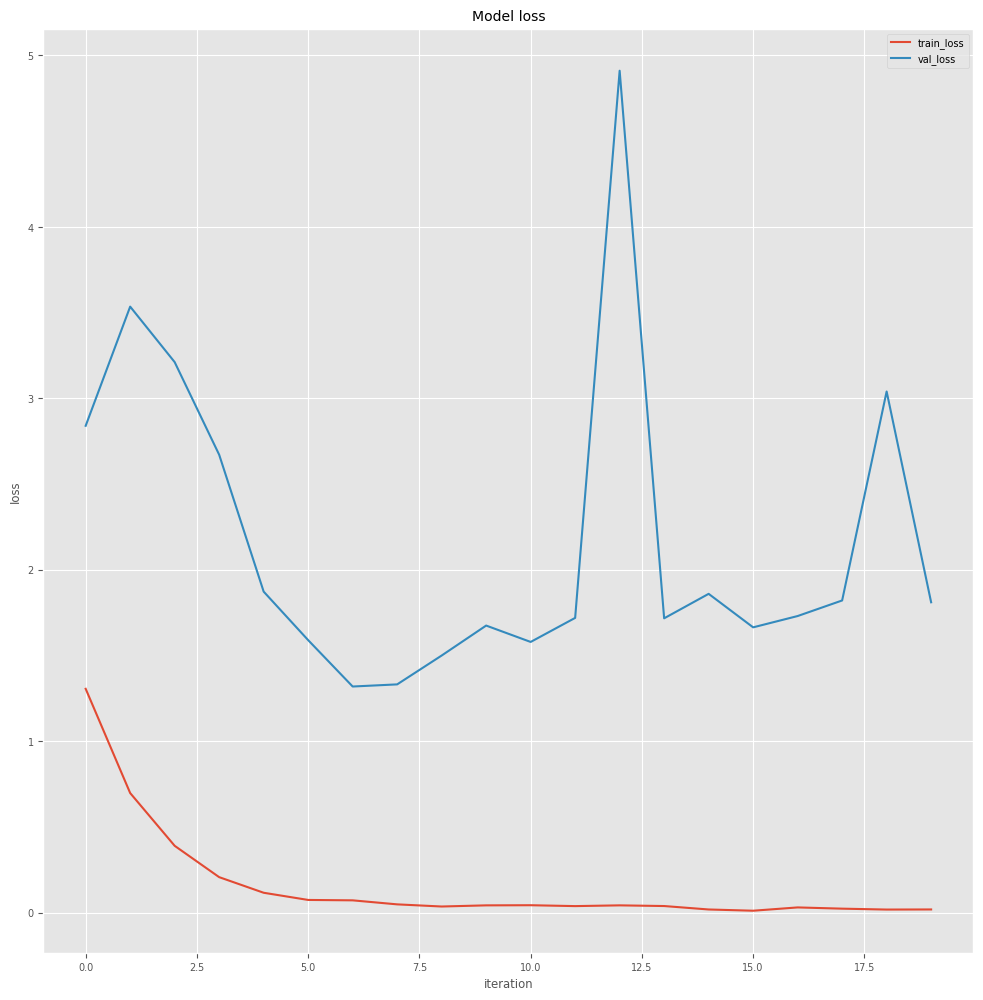

In [49]:
# plot findings
plt.plot(conv_logs.history['loss'])
plt.plot(conv_logs.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()


In [53]:
# confirm metrics
conv_layers.evaluate(X_test)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.5554 - f1_score: 0.5554 - loss: 2.0721 - precision_2: 0.5754 - recall_2: 0.5394 - top_k_accuracy: 0.7289


[2.072129964828491,
 0.5553935766220093,
 0.728863000869751,
 0.5393586158752441,
 0.5754277110099792,
 0.5553935170173645]

### Model Testing & Evaluation

In [20]:
# testing with different datasets
X_test2 = tf.keras.utils.image_dataset_from_directory(
	test2_directory,
	labels = 'inferred',
	label_mode = 'categorical',
	class_names = label_list,
	color_mode = 'rgb',
	image_size = (IMAGE_SIZE, IMAGE_SIZE),
	shuffle = True,
	seed = 1203 
)


Found 17 files belonging to 10 classes.


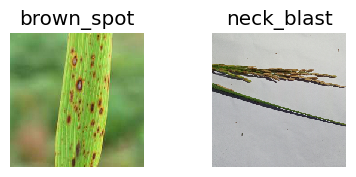

In [22]:
for test_image, test_label in X_test2.take(1):

# raw = tf.io.read_file(test2_directory)
# image = tf.image.decode_image(raw, channels=3)
# image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3]) # rescale
    for i in range(2):
        
        ax = plt.subplot(4,4,i+1)
        plt.imshow(test_image[i]/255.)
        plt.title(label_list[tf.argmax(test_label[i], axis=0).numpy()])
        plt.axis("off")
plt.show()


In [17]:
# test image outside of dataset
res = conv_layers(tf.expand_dims(test_image[0], axis=0))
label_pred = label_list[tf.math.argmax(res, axis=1).numpy()[0]]
print("Predicted label: ", label_pred) # fix later
print(label_list[tf.argmax(test_label[0], axis=-1)])
#assert(label_pred == (label_list[tf.argmax(test_label[0], axis=-1)]))

tf.Tensor(
[[6.3282400e-01 3.6659222e-03 4.5841308e-03 3.0704087e-01 3.1968836e-02
  1.2088304e-02 7.5014796e-05 1.0606208e-03 2.6689204e-03 4.0233810e-03]], shape=(1, 10), dtype=float32)
Predicted label:  tungro
leaf_scald


AssertionError: 

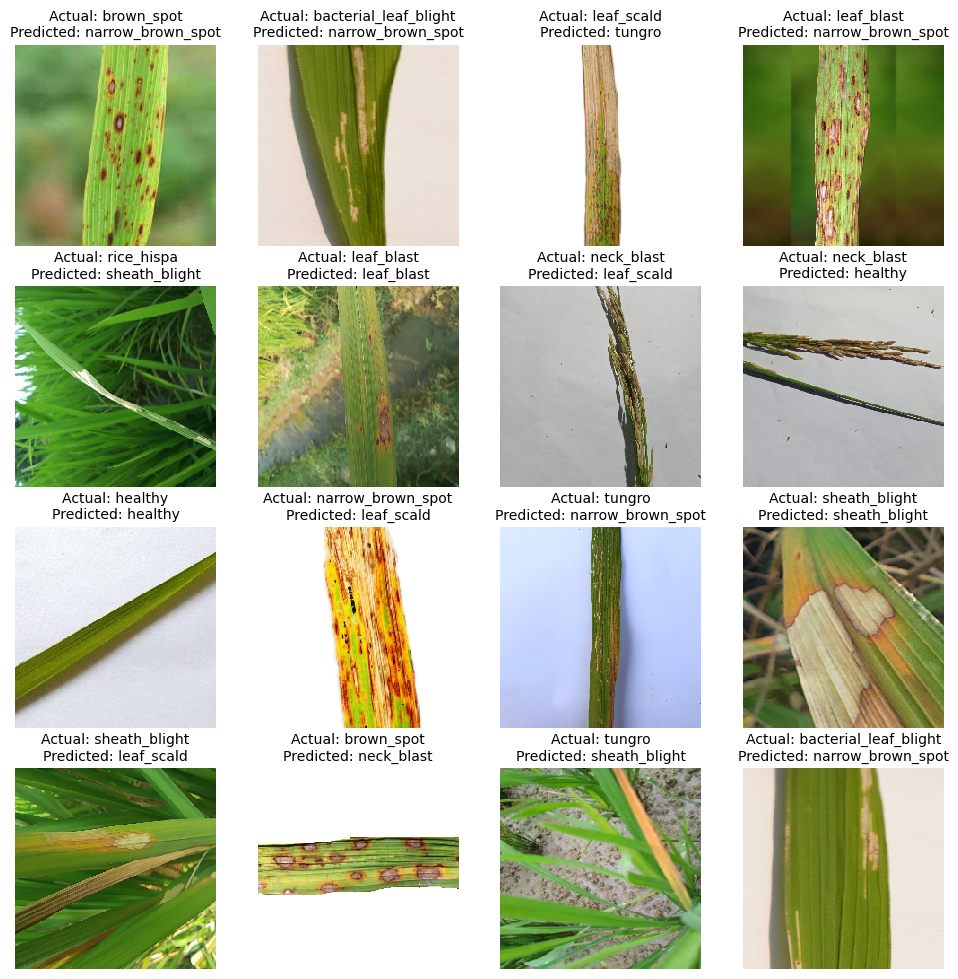

In [30]:
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.rcParams['font.size'] = 7

# Display chosen predictions
for images, labels in X_test2.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        string = "Actual: " + label_list[tf.math.argmax(labels[i], axis=0).numpy()] + "\nPredicted: " + label_list[tf.math.argmax(conv_layers(tf.expand_dims(images[i], axis=0)), axis = -1).numpy()[0]] 
        plt.title(string)
                    # Axis changed to last since tensor rank > 2
        plt.axis("off")

plt.show()